#### 导入数据

In [1]:
# 导入数据
import numpy as np
import scipy.io as scio
offline_data = scio.loadmat('offline_data_random.mat')
online_data = scio.loadmat('online_data.mat')
offline_location, offline_rss = offline_data['offline_location'], offline_data['offline_rss']
trace, rss = online_data['trace'][0:1000, :], online_data['rss'][0:1000, :]
del offline_data
del online_data

In [2]:
# 定位准确度
def accuracy(predictions, labels):
    return np.mean(np.sqrt(np.sum((predictions - labels)**2, 1)))

#### knn回归

In [3]:
# knn回归
from sklearn import neighbors
knn_reg = neighbors.KNeighborsRegressor(40, weights='uniform', metric='euclidean')
predictions = knn_reg.fit(offline_rss, offline_location).predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, "m"

accuracy:  2.24421479398 m


#### knn分类

In [4]:
# knn分类，需要把坐标转换成网格标号，预测后将网格标号转换为坐标
labels = np.round(offline_location[:, 0]/100.0) * 100 + np.round(offline_location[:, 1]/100.0)
from sklearn import neighbors
knn_cls = neighbors.KNeighborsClassifier(n_neighbors=40, weights='uniform', metric='euclidean')
predict_labels = knn_cls.fit(offline_rss, labels).predict(rss)
x = np.floor(predict_labels/100.0)
y = predict_labels - x * 100
predictions = np.column_stack((x, y)) * 100
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, 'm'

accuracy:  2.73213398632 m


#### 定位算法分析

加入数据预处理和交叉验证

In [5]:
# 预处理，标准化数据(其实RSS数据还算正常，不预处理应该也无所谓，特征选择什么的也都不需要)
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler().fit(offline_rss)
X_train = standard_scaler.transform(offline_rss)
Y_train = offline_location
X_test = standard_scaler.transform(rss)
Y_test = trace

In [44]:
# 交叉验证，在knn里用来选择最优的超参数k
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
parameters = {'n_neighbors':range(1, 50)}
knn_reg = neighbors.KNeighborsRegressor(weights='uniform', metric='euclidean')
clf = GridSearchCV(knn_reg, parameters)
clf.fit(offline_rss, offline_location)
scores = clf.cv_results_['mean_test_score']
k = np.argmax(scores) #选择score最大的k

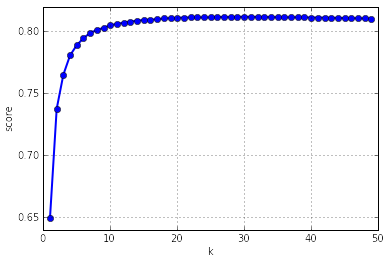

In [49]:
# 绘制超参数k与score的关系曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(1, scores.shape[0] + 1), scores, '-o', linewidth=2.0)
plt.xlabel("k")
plt.ylabel("score")
plt.grid(True)
plt.show()

In [47]:
# 使用最优的k做knn回归
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform', metric='euclidean')
predictions = knn_reg.fit(offline_rss, offline_location).predict(rss)
acc = accuracy(predictions, trace)
print "accuracy: ", acc/100, "m"

accuracy:  2.22455511073 m


In [66]:
# 训练数据量与accuracy
k = 29
data_num = range(100, 30000, 300)
acc = []
for i in data_num:
    knn_reg = neighbors.KNeighborsRegressor(n_neighbors=k, weights='uniform', metric='euclidean')
    predictions = knn_reg.fit(offline_rss[:i, :], offline_location[:i, :]).predict(rss)
    acc.append(accuracy(predictions, trace) / 100)

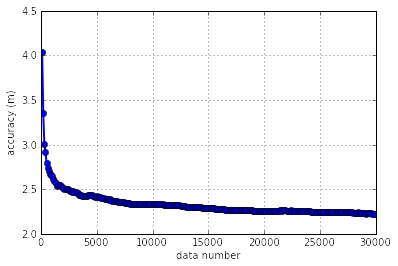

In [65]:
# 绘制训练数据量与accuracy的曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(data_num, acc, '-o', linewidth=2.0)
plt.xlabel("data number")
plt.ylabel("accuracy (m)")
plt.grid(True)
plt.show()